# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<br>
<img src='images/AI_Programming_with_Python_ND_P2_L_23.png' width="800" height=auto>
<br>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

# Start from the next cell below for classifier training
Override default architecture name, learning rate, dropout rate, epochs in the cell *"set args"*

Training in CPU mode is possible but not practical, please run training in GPU mode 

*tip : if utilizing Udacity lab environment, save all your changes prior clicking GPU "Enable/Disble" button to avoid loss of unsaved changes* 


In [1]:
# Jupyter notebook settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Standard library imports
import glob
import json
import os
import sys
from datetime import datetime

# Third-party imports
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from tqdm import tqdm
from PIL import Image

# Local imports
# from workspace_utils import active_session
# from helper.common_utils import set_device_for_gpu, print_device_info
# from helper.input import get_train_input_arg
# from helper.load import transform_load
# from helper.validate import validate_train_args

This code implements a keep-alive mechanism for maintaining an active session in a Udacity workspace environment by periodically sending HTTP requests to prevent timeouts, featuring utility functions that wrap long-running operations to ensure the workspace remains responsive during extended computational tasks.

In [ ]:
import signal
from contextlib import contextmanager
import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

In [2]:
# define the constants

data_dir = './flowers'
test_dir = data_dir + '/test'
chkptdir = 'chksav'
model_names = ['densenet121', 'densenet161', 'resnet18', 'vgg16']
load_types = ['train', 'valid', 'test']
datadir = 'flowers'
savedir = 'chksav'

In [3]:
def set_device_for_gpu():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda:0")
    return torch.device("cpu")

def print_device_info(device, args):
    gpu_type = {
        'mps': 'Apple GPU',
        'cuda': 'NVIDIA GPU',
        'cpu': 'CPU'
    }.get(device.type, 'Unknown')

    if device.type == 'cpu' and args.gpu:
        print(f"*** GPU is unavailable, using {gpu_type} ...\n")
    else:
        action = "using" if args.gpu else "training model using"
        print(f"*** {action} {gpu_type} ...\n")

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image`
# function works, running the output through this function should return the original image (except for the cropped out
# portions).

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.imshow(image)

    return ax

def pick_a_pic(dataloaders, dset_dir, dset_type, args):

    args.z_imgcls = np.random.choice(dataloaders[dset_type].dataset.classes)
    args.z_rndimg = np.random.choice(os.listdir(dset_dir + '/' + args.z_imgcls))
    args.z_rndimgpth = dset_dir + '/' + args.z_imgcls + '/' + args.z_rndimg

    return args


def process_image(image: Image.Image) -> np.ndarray:
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model.

    Args:
        image (PIL.Image.Image): The input PIL image.

    Returns:
        np.ndarray: Processed image as a NumPy array.

    The function performs the following steps:
        1. Resizes the image to have a short side of 256 pixels while maintaining the aspect ratio.
        2. Crops the center 224x224 portion of the image.
        3. Normalizes the image values.
        4. Transposes the image to have the color channel in the first position.
    """
    short_side = 256
    crop_size = 224

    width, height = image.size
    aspect_ratio = width / height

    if height < width:
        new_height = short_side
        new_width = int(new_height * aspect_ratio)
    else:
        new_width = short_side
        new_height = int(new_width / aspect_ratio)

    resized_img = image.resize((new_width, new_height))

    left = (new_width - crop_size) // 2
    top = (new_height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    cropped_img = resized_img.crop((left, top, right, bottom))

    np_img = np.array(cropped_img) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    normalized_img = (np_img - mean) / std

    return normalized_img.transpose((2, 0, 1))

In [ ]:
def check_point():
    if len(glob.glob(chkptdir + '/*.pth')) > 0:
        checkpt = max(glob.glob(chkptdir + '/*.pth'), key=os.path.getctime)
    else:
        checkpt = None
        print('\n*** no saved checkpoint to load ... exiting\n')
        sys.exit(1)

    return checkpt


def load_categories():
    with open('./cat_to_name.json', 'r') as f:
        return json.load(f)


def transform_load(args):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # define transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize])
    }

    image_datasets = {k: datasets.ImageFolder(os.path.join(args.data_dir, k), transform=data_transforms[k])
                      for k in ['train', 'valid', 'test']}

    dataloaders = {k: torch.utils.data.DataLoader(image_datasets[k], batch_size=64, shuffle=True)
                   for k in ['train', 'valid', 'test']}

    return dataloaders, image_datasets


def load_checkpoint(device, args):
    if device.type == 'cuda':
        print('*** loading chkpt', args.checkpoint, ' in cuda ...\n')
        checkpoint = torch.load(args.checkpoint)
    else:
        print('*** loading chkpt', args.checkpoint, ' in cpu ...\n')
        checkpoint = torch.load(args.checkpoint, map_location=lambda storage, loc: storage)

    model = models.__dict__[checkpoint['arch']](pretrained=True)
    if checkpoint['arch'] == 'resnet18':
        model.fc = checkpoint['fc']
        print('architecture:', checkpoint['arch'], '\nmodel.fc:\n', model.fc, '\n')
    else:
        model.classifier = checkpoint['classifier']
        print('architecture:', checkpoint['arch'], '\nmodel.classifier:\n', model.classifier, '\n')
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])

    return model, checkpoint['arch']


In [ ]:
from pathlib import Path


def validate_path(path, description):
    if not Path(path).exists():
        print(f"*** {description}: '{path}' not found ... exiting\n")
        sys.exit(1)

def validate_positive(value, name, allow_zero=False):
    if (allow_zero and value < 0) or (not allow_zero and value <= 0):
        print(f"*** {name} must be {'non-negative' if allow_zero else 'positive'} ... exiting\n")
        sys.exit(1)


def validate_hidden_units(hidden_units):
    if hidden_units:
        try:
            list(map(int, hidden_units.split(',')))
        except ValueError:
            print(f"Hidden units contain non-numeric value(s): [{hidden_units}] ... exiting\n")
            sys.exit(1)


def validate_train_args(args):
    validate_path(args.data_dir, "Data directory")
    validate_positive(args.learning_rate, "Learning rate")
    validate_positive(args.dropout, "Dropout", allow_zero=True)
    validate_positive(args.epochs, "Epochs")

    if args.arch != 'resnet18':
        validate_hidden_units(args.hidden_units)


def validate_predict_args(args):
    validate_path(args.checkpoint, "Checkpoint")
    validate_path(args.img_pth, "Image path")
    validate_path(args.category_names, "Category names mapper file")
    validate_positive(args.top_k, "Number of top k classes to print")


In [ ]:
import argparse

def create_common_args(parser):
    parser.add_argument('data_dir', type=str, nargs='?', default=data_dir,
                        help='path to datasets')
    parser.add_argument('--gpu', action='store_true',
                        help='use GPU for processing')


def get_predict_input_args():
    parser = argparse.ArgumentParser()
    create_common_args(parser)

    parser.add_argument('checkpoint', type=str, nargs='?', default=check_point(),
                        help='path to saved checkpoint')
    parser.add_argument('-img', '--img_pth', type=str, default=f'{test_dir}/69/image_05959.jpg',
                        help='path to an image file')
    parser.add_argument('-cat', '--category_names', type=str, default='cat_to_name.json',
                        help='path to JSON file for mapping class values to category names')
    parser.add_argument('-k', '--top_k', type=int, default=1,
                        help='no. of top k classes to print')

    return parser.parse_args()

def get_predict_input_arg(in_arg=None):
    parser = argparse.ArgumentParser()
    create_common_args(parser)

    parser.add_argument('checkpoint', type=str, nargs='?', default=check_point(),
                        help='path to saved checkpoint')
    parser.add_argument('-img', '--img_pth', type=str, default=f'{test_dir}/69/image_05959.jpg',
                        help='path to an image file')
    parser.add_argument('-cat', '--category_names', type=str, default='cat_to_name.json',
                        help='path to JSON file for mapping class values to category names')
    parser.add_argument('-k', '--top_k', type=int, default=1,
                        help='no. of top k classes to print')

    if in_arg is None:
        return parser.parse_args([])
    else:
        return parser.parse_args(in_arg)


def get_train_input_args():
    parser = argparse.ArgumentParser()
    create_common_args(parser)

    parser.add_argument('--save_dir', type=str, default=savedir,
                        help='path to checkpoint directory')
    parser.add_argument('--arch', default='densenet121', choices=model_names,
                        help=f'model architecture: {" | ".join(model_names)} (default: densenet121)')
    parser.add_argument('-lr', '--learning_rate', type=float, default=0.001,
                        help='learning rate (default: 0.001)')
    parser.add_argument('-dout', '--dropout', type=float, default=0.5,
                        help='dropout rate (default: 0.5)')
    parser.add_argument('-hu', '--hidden_units', type=str,
                        help="hidden units, one or multiple values (comma separated) enclosed in single quotes. "
                             "Ex1. one value: '500' Ex2. multiple values: '1000, 500'")
    parser.add_argument('-e', '--epochs', type=int, default=3,
                        help='total no. of epochs to run (default: 3)')

    return parser.parse_args()

def get_train_input_arg(in_arg=None):
    parser = argparse.ArgumentParser()
    parser.add_argument('data_dir', type=str, nargs='?', default=data_dir,
                        help='path to datasets')
    parser.add_argument('--gpu', action='store_true',
                        help='use GPU for processing')
    parser.add_argument('--save_dir', type=str, default=savedir,
                        help='path to checkpoint directory')
    parser.add_argument('--arch', default='densenet121', choices=model_names,
                        help=f'model architecture: {" | ".join(model_names)} (default: densenet121)')
    parser.add_argument('-lr', '--learning_rate', type=float, default=0.001,
                        help='learning rate (default: 0.001)')
    parser.add_argument('-dout', '--dropout', type=float, default=0.5,
                        help='dropout rate (default: 0.5)')
    parser.add_argument('-hu', '--hidden_units', type=str,
                        help="hidden units, one or multiple values (comma separated) enclosed in single quotes. "
                             "Ex1. one value: '500' Ex2. multiple values: '1000, 500'")
    parser.add_argument('-e', '--epochs', type=int, default=3,
                        help='total no. of epochs to run (default: 3)')

    # Parse known args only
    if in_arg is None:
        return parser.parse_args([])
    else:
        return parser.parse_args(in_arg)

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = './flowers'
test_dir = data_dir + '/test'
chkptdir = 'chksav'
model_names = ['densenet121', 'densenet161', 'resnet18', 'vgg16']
load_types = ['train', 'valid', 'test']
datadir = 'flowers'
savedir = 'chksav'

In [4]:
def transform_load(data_dir):

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),

        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize]),

        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize])
    }

    image_datasets = {k: datasets.ImageFolder(os.path.join(data_dir, k), transform=data_transforms[k])
                      for k in ['train', 'valid', 'test']}

    dataloaders = {k: torch.utils.data.DataLoader(image_datasets[k], batch_size=64, shuffle=True)
                   for k in ['train', 'valid', 'test']}

    return dataloaders, image_datasets


data_dir = './flowers'
dataloaders, image_datasets = transform_load(data_dir)

print('Transform load is completed')


Transform load is completed


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json

def load_categories():
    with open('./cat_to_name.json', 'r') as f:
        return json.load(f)

data = load_categories()
print ('flower data loading is completed!')

flower data loading is completed!


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

## set args
set your desired architecture, learning rate, drop out rate, epochs, interval for printing results during training

In [19]:
args = get_train_input_arg([])

args.data_dir = './flowers'
args.save_dir = 'chksav'
args.arch = 'densenet121'
args.learning_rate = 0.001
args.dropout = 0.5
args.hidden_units = '500'
args.epochs = 1
args.gpu = True

print('Args list:\n',[i for i in dir(args)])

Args list:
 ['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_args', '_get_kwargs', 'arch', 'data_dir', 'dropout', 'epochs', 'gpu', 'hidden_units', 'learning_rate', 'save_dir']


In [8]:
print('\n*** command line arguments ***')
print(f'architecture: {args.arch}\ndata dir: {args.data_dir}\nchkpt dir: {args.save_dir}'
      f'\nlearning rate: {args.learning_rate}\ndropout: {args.dropout}'
      f'\nhidden layer: {args.hidden_units}\nepochs: {args.epochs}\nGPU mode: {args.gpu}\n')

device = set_device_for_gpu()

print('\n*** command line arguments ***')
print(f'architecture: {args.arch}\ndata dir: {args.data_dir}\nchkpt dir: {args.save_dir}'
      f'\nlearning rate: {args.learning_rate}\ndropout: {args.dropout}'
      f'\nhidden layer: {args.hidden_units}\nepochs: {args.epochs}\nGPU mode: {args.gpu}\n')

validate_train_args(args)
print_device_info(device, args)

dataloaders, image_datasets = transform_load(args)

model = models.__dict__[args.arch](pretrained=True)

for param in model.parameters():
    param.requires_grad = False




*** command line arguments ***
architecture: densenet121
data dir: ./flowers
chkpt dir: chksav
learning rate: 0.001
dropout: 0.5
hidden layer: 500
epochs: 1
GPU mode: True


*** command line arguments ***
architecture: densenet121
data dir: ./flowers
chkpt dir: chksav
learning rate: 0.001
dropout: 0.5
hidden layer: 500
epochs: 1
GPU mode: True

*** using Apple GPU ...


Classifier architecture:
  Layer 0: Linear(in_features=1024, out_features=500, bias=True)
  Layer 1: ReLU()
  Layer 2: Dropout(p=0.5, inplace=False)
  Layer 3: Linear(in_features=500, out_features=102, bias=True)
  Layer 4: LogSoftmax(dim=1)

*** model architecture: densenet121
*** Classifier:
Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=500, out_features=102, bias=True)
  (4): LogSoftmax(dim=1)
)


*** checkpoint: 20240919_122037_densenet121.pth, saved to: chksav

Starting training...
Epochs: 1, Print frequency: 40

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.78it/s]

Train Loss: 3.6269 Acc: 0.2265
Valid Loss: 2.0605 Acc: 0.6198


Training complete in 0:00:43.729920
Best val Loss: 2.060514
Training completed.


## Neural Network Classifier Construction Explanation

The `build_classifier` function constructs a custom classifier for different pre-trained models. Here's the detailed breakdown:

### 1. Input Size Mapping

```python
in_size = {
    'densenet121': 1024,
    'densenet161': 2208,
    'vgg16': 25088,
}
```

This dictionary maps different pre-trained models to their respective output feature sizes:
* DenseNet121: 1024 features
* DenseNet161: 2208 features
* VGG16: 25088 features

### 2. Architecture Validation

The code checks if the requested architecture (`args.arch`) is supported. If not, it raises a ValueError.

### 3. Output Layer Configuration

* `output_size`: Determined by the number of classes in the training dataset
* `hidden_layers`: Configured through `args.hidden_units`
  * Can be a comma-separated string of integers
  * Defines the size of each hidden layer
  * Defaults to [500] if not provided

### 4. Layer Construction

The classifier is built as a sequence of layers. For each pair of consecutive sizes in `layer_sizes`, it creates:

* Linear layer for transformation
* ReLU activation for non-linearity
* Dropout layer (using `args.dropout` rate) for regularization

The final output layer includes:
* Linear layer mapping to the number of classes
* LogSoftmax activation for producing log probabilities

### 5. Model Assembly

* All layers are combined into a `nn.Sequential` module
* The classifier replaces the original classifier in the pre-trained model
* The architecture is printed for visualization

### Transfer Learning Setup

This represents a typical transfer learning configuration where:

* Pre-trained model's feature extractor remains frozen
* New classifier maps extracted features to desired classes
* Dropout prevents overfitting
* LogSoftmax pairs with NLL loss for training

### Design Flexibility

The design accommodates:

* Multiple pre-trained models (DenseNet121, DenseNet161, VGG16)
* Customizable number and size of hidden layers
* Adjustable dropout rate for regularization
* Easy architecture visualization

In [ ]:
def build_classifier(model, args, dataloaders):
    in_size = {
        'densenet121': 1024,
        'densenet161': 2208,
        'vgg16': 25088,
    }

    if args.arch not in in_size:
        raise ValueError(f"Unsupported architecture: {args.arch}")

    output_size = len(dataloaders['train'].dataset.classes)
    hidden_layers = [int(units) for units in args.hidden_units.split(',')] if args.hidden_units else [500]

    layers = []
    layer_sizes = [in_size[args.arch]] + hidden_layers

    for i in range(len(layer_sizes) - 1):
        layers.extend([
            nn.Linear(layer_sizes[i], layer_sizes[i + 1]),
            nn.ReLU(),
            nn.Dropout(args.dropout)
        ])

    layers.extend([
        nn.Linear(layer_sizes[-1], output_size),
        nn.LogSoftmax(dim=1)
    ])

    model.classifier = nn.Sequential(*layers)

    print("\nClassifier architecture:")
    for i, layer in enumerate(model.classifier):
        print(f"  Layer {i}: {layer}")

    return model


## Build a classifier

### Load a pre-trained model and override with own classifier

<!-- model = models.__dict__[args.z_arch](pretrained=True)    
model = build_classifier(model, args)
print('\nmodel architecture:', args.z_arch, '\n')
model.classifier -->

criterion, model, optimizer = configure_model_for_training(args, dataloaders, model)

In [9]:
def configure_model_for_training(args, dataloaders, model):
    if args.arch == 'resnet18':
        model.fc = nn.Linear(model.fc.in_features, len(dataloaders['train'].dataset.classes))
        print(f'\n*** model architecture: {args.arch}')
        print(f'*** fc:\n{model.fc}\n')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.fc.parameters(), lr=args.learning_rate)
    else:
        model = build_classifier(model, args, dataloaders)
        print(f'\n*** model architecture: {args.arch}')
        print(f'*** Classifier:\n{model.classifier}\n')
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.classifier.parameters(), args.learning_rate)
    return criterion, model, optimizer

criterion, model, optimizer = configure_model_for_training(args, dataloaders, model)


Classifier architecture:
  Layer 0: Linear(in_features=1024, out_features=500, bias=True)
  Layer 1: ReLU()
  Layer 2: Dropout(p=0.5, inplace=False)
  Layer 3: Linear(in_features=500, out_features=102, bias=True)
  Layer 4: LogSoftmax(dim=1)

*** model architecture: densenet121
*** Classifier:
Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=500, out_features=102, bias=True)
  (4): LogSoftmax(dim=1)
)



### Training One Epoch Function Explanation


### 1. Setup Phase

```python
model.train()  # Sets the model to training mode
running_loss = 0.0
running_corrects = 0
total_samples = 0
```

* `model.train()` enables training-specific behaviors like dropout
* Initialize counters to track loss and accuracy

### 2. Training Loop

```python
for inputs, labels in tqdm(dataloader, desc='Training'):
    inputs, labels = inputs.to(device), labels.to(device)
```

* Iterates over training data using `tqdm` for progress visualization
* Moves input images and labels to specified device (CPU/GPU)

### 3. Forward Pass

```python
optimizer.zero_grad()  # Clear previous gradients
outputs = model(inputs)  # Get model predictions
_, preds = torch.max(outputs, 1)  # Get the predicted classes
loss = criterion(outputs, labels)  # Calculate loss
```

* Resets gradients to prevent accumulation
* Runs inputs through the model
* Uses `torch.max` to get predicted class
* Calculates loss between predictions and true labels

### 4. Backward Pass

```python
loss.backward()  # Compute gradients
optimizer.step()  # Update weights
```

* Computes gradients through backpropagation
* Updates model parameters using the optimizer

### 5. Statistics Tracking

```python
running_loss += loss.item() * inputs.size(0)
running_corrects += torch.sum(preds == labels.data).item()
total_samples += inputs.size(0)
```

* Accumulates total loss (scaled by batch size)
* Counts correct predictions
* Keeps track of total processed samples

### 6. Final Metrics

```python
epoch_loss = running_loss / total_samples
epoch_acc = running_corrects / total_samples
```

* Calculates average loss and accuracy for the epoch

Returns both epoch's average loss and accuracy, useful for:
* Monitoring training progress
* Implementing early stopping
* Learning rate scheduling

This implementation follows PyTorch best practices with proper:
* Gradient handling
* Device management
* Metric calculation

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

In [ ]:
def validate(model, dataloader, criterion, device):

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

This **train** implements a complete training loop that trains a model for a specified number of epochs while monitoring both training and validation metrics. It includes learning rate scheduling (ReduceLROnPlateau) to reduce the learning rate when validation loss plateaus, and implements early stopping if the model doesn't improve for a specified number of epochs. The function keeps track of the best model weights based on validation loss and restores them at the end of training, returning the model in its best performing state.


In [ ]:
def train(model, dataloaders, optimizer, criterion, epochs=3, print_freq=20, lr=0.001, device='cpu', patience=5):
    
    model.to(device)
    start_time = datetime.now()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

    print(f'Epochs: {epochs}, Print frequency: {print_freq}, Initial LR: {lr}\n')

    best_val_loss = float('inf')
    best_model_wts = model.state_dict()
    no_improve = 0

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_loss, train_acc = train_one_epoch(model, dataloaders['train'], optimizer, criterion, device)
        val_loss, val_acc = validate(model, dataloaders['valid'], criterion, device)

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Valid Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve == patience:
            print("Early stopping")
            break

        print()

    elapsed = datetime.now() - start_time
    print(f'\nTraining complete in {elapsed}')
    print(f'Best val Loss: {best_val_loss:4f}')

    model.load_state_dict(best_model_wts)
    return model


In [13]:
model = model.cpu()
model.class_to_idx = dataloaders['train'].dataset.class_to_idx

print("Starting training...")
model = train(model, dataloaders, optimizer, criterion, args.epochs, 40, args.learning_rate, device)
print("Training completed.")

/opt/miniconda3/envs/aipnd/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



*** checkpoint: 20240919_122840_densenet121.pth, saved to: chksav

Starting training...
Epochs: 1, Print frequency: 40, Initial LR: 0.001

Epoch 1/1
----------


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.75it/s]

Train Loss: 1.7762 Acc: 0.5708
Valid Loss: 0.8474 Acc: 0.8350


Training complete in 0:00:44.260287
Best val Loss: 0.847400
Training completed.


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
def test(model, dataloaders, criterion, device):
    print('\n*** Evaluating model on test set ***\n')
    model.to(device)
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    start_time = datetime.now()

    with torch.no_grad():
        for images, labels in tqdm(dataloaders['test'], desc='Testing'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / total
    accuracy = 100 * correct / total

    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    elapsed = datetime.now() - start_time
    print(f'\n*** Test evaluation completed ***')
    print(f'Elapsed time: {elapsed}')

    return avg_loss, accuracy

print("Starting testing...")
test_loss, test_accuracy = test(model, dataloaders, criterion, device)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")
print("Testing completed.")


Starting testing...

*** Evaluating model on test set ***



Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]

Test Loss: 0.8959
Test Accuracy: 81.20%

*** Test evaluation completed ***
Elapsed time: 0:00:06.109761
Final Test Loss: 0.8959, Final Test Accuracy: 81.20%
Testing completed.


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
os.makedirs(args.save_dir, exist_ok=True)

checkpoint = {
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'optimizer': optimizer.state_dict(),
    'arch': args.arch,
    'lrate': args.learning_rate,
    'epochs': args.epochs,
    'fc' if args.arch == 'resnet18' else 'classifier': model.fc if args.arch == 'resnet18' else model.classifier
}

chkpt = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{args.arch}.pth"
checkpt = os.path.join(args.save_dir, chkpt)

torch.save(checkpoint, checkpt)
print(f'\n*** checkpoint: {chkpt}, saved to: {os.path.dirname(checkpt)}\n')

*** checkpoint:  20180726_072018_densenet121.pth , saved to:  chksav


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
def load_checkpoint(device, args):
    if device.type == 'cuda':
        print('*** loading chkpt', args.checkpoint, ' in cuda ...\n')
        checkpoint = torch.load(args.checkpoint)
    else:
        print('*** loading chkpt', args.checkpoint, ' in cpu ...\n')
        checkpoint = torch.load(args.checkpoint, map_location=lambda storage, loc: storage)

    model = models.__dict__[checkpoint['arch']](pretrained=True)
    if checkpoint['arch'] == 'resnet18':
        model.fc = checkpoint['fc']
        print('architecture:', checkpoint['arch'], '\nmodel.fc:\n', model.fc, '\n')
    else:
        model.classifier = checkpoint['classifier']
        print('architecture:', checkpoint['arch'], '\nmodel.classifier:\n', model.classifier, '\n')
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])

    return model, checkpoint['arch']
    

In [19]:
if checkpt:
    model, args = load_checkpoint(checkpt)
    # check results
    print('model architecture:', args.z_arch, '\n')
    print('model.classifier:\n', model.classifier)
else:
    print('\n*** stop !!! no saved checkpoint to load \n')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


model architecture: densenet121 

model.classifier:
 Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=102, bias=True)
  (3): LogSoftmax()
)


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
def process_image(image: Image.Image) -> np.ndarray:
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model.

    Args:
        image (PIL.Image.Image): The input PIL image.

    Returns:
        np.ndarray: Processed image as a NumPy array.

    The function performs the following steps:
    1. Resizes the image to have a short side of 256 pixels while maintaining the aspect ratio.
    2. Crops the center 224x224 portion of the image.
    3. Normalizes the image values.
    4. Transposes the image to have the color channel in the first position.
    """
    short_side = 256
    crop_size = 224

    width, height = image.size
    aspect_ratio = width / height

    if height < width:
        new_height = short_side
        new_width = int(new_height * aspect_ratio)
    else:
        new_width = short_side
        new_height = int(new_width / aspect_ratio)

    resized_img = image.resize((new_width, new_height))

    left = (new_width - crop_size) // 2
    top = (new_height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    cropped_img = resized_img.crop((left, top, right, bottom))

    np_img = np.array(cropped_img) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    normalized_img = (np_img - mean) / std

    return normalized_img.transpose((2, 0, 1))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [21]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

In [22]:
def pick_a_pic(dataloaders, dset_dir, dset_type, args):
    
    args.z_imgcls = np.random.choice(dataloaders[dset_type].dataset.classes)
    args.z_rndimg = np.random.choice(os.listdir(dset_dir + '/' + args.z_imgcls))
    args.z_rndimgpth = dset_dir + '/' + args.z_imgcls + '/' + args.z_rndimg

    return args

In [14]:
from helper.image import pick_a_pic 
from helper.constant import test_dir
from helper.validate import validate_predict_args
from helper.input import get_predict_input_arg
from helper.load import transform_load
from helper.load import load_checkpoint
from helper.common_utils import set_device_for_gpu
from datetime import datetime


device = set_device_for_gpu()
args = get_predict_input_arg([])

print('\n*** Command line arguments ***')
print(f'Checkpoint: {args.checkpoint}\nImage path: {args.img_pth}'
      f'\nCategory names mapper file: {args.category_names}\nNumber of top k: {args.top_k}'
      f'\nGPU mode: {args.gpu}\n')

validate_predict_args(args)

dataloaders, _ = transform_load(args)
model, arch = load_checkpoint(device, args)


*** Command line arguments ***
Checkpoint: chksav/20240919_122840_densenet121.pth
Image path: ./flowers/test/69/image_05959.jpg
Category names mapper file: cat_to_name.json
Number of top k: 1
GPU mode: False

*** loading chkpt chksav/20240919_122840_densenet121.pth  in cpu ...

architecture: densenet121 
model.classifier:
 Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=500, out_features=102, bias=True)
  (4): LogSoftmax(dim=1)
) 



In [15]:
args = pick_a_pic(dataloaders, test_dir, 'test', args)
image_path = args.z_rndimgpth

print(f'Image path: {image_path}\n')

Image path: ./flowers/test/76/image_02484.jpg



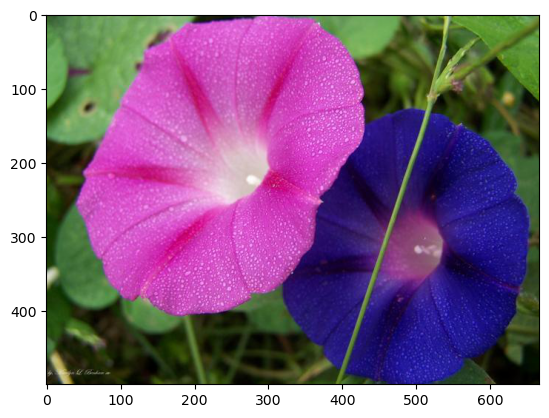

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

with Image.open(image_path) as image:
    plt.imshow(image)

### Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [26]:
def predict(model, arch, image_path, topk=5, device='cpu'):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    """
    model.eval().to(device)
    cat_to_name = load_categories()

    image = process_image(Image.open(image_path))
    image = torch.FloatTensor(image).unsqueeze_(0).to(device)

    with torch.no_grad():
        output = model(image)
        ps = F.softmax(output, dim=1) if arch == 'resnet18' else torch.exp(output)
        topk_prob, topk_idx = ps.topk(topk)

    topk_probs = topk_prob.cpu().numpy()[0]
    topk_idxs = topk_idx.cpu().numpy()[0]

    idx_to_class = {i: k for k, i in model.class_to_idx.items()}
    topk_classes = [idx_to_class[i] for i in topk_idxs]
    topk_names = [cat_to_name[i] for i in topk_classes]

    print(f'*** Top {topk} classes ***')
    print('Class names:   ', topk_names)
    print('Classes:       ', topk_classes)
    print('Probabilities: ', topk_probs)

    return topk_classes, topk_names, topk_probs


In [21]:
def show_classifier(topk_names, topk_probs, img_path):
    """
    Display the image and a bar chart of top class probabilities.
    """
    img = Image.open(img_path)
    img_name = topk_names[0]

    fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
    ax1.set_title(img_name)
    ax1.imshow(img)
    ax1.axis('off')

    y_pos = np.arange(len(topk_probs))
    ax2.barh(y_pos, topk_probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(topk_names)
    ax2.invert_yaxis()
    ax2.set_title('Class Probability')

    plt.tight_layout()
    plt.show()


*** Command line arguments ***
Checkpoint: chksav/20240919_122840_densenet121.pth
Image path: ./flowers/test/69/image_05959.jpg
Category names mapper file: cat_to_name.json
Number of top k: 5
GPU mode: False

*** training model using Apple GPU ...

*** loading chkpt chksav/20240919_122840_densenet121.pth  in cpu ...

architecture: densenet121 
model.classifier:
 Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=500, out_features=102, bias=True)
  (4): LogSoftmax(dim=1)
) 


*** Prediction setup done!
Elapsed time: 0:00:00.183806

Image path: ./flowers/test/63/image_05878.jpg

Predicting top classes and probabilities...


/Users/chaklader/PycharmProjects/image-classifier/helper/load.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.checkpoint, map_location=lamb

*** Top 5 classes ***
Class names:    ['black-eyed susan', 'gazania', 'english marigold', 'barbeton daisy', 'californian poppy']
Classes:        ['63', '71', '5', '41', '65']
Probabilities:  [0.205338   0.09051239 0.08923694 0.08302309 0.08157433]
Prediction complete.
Displaying classification results...


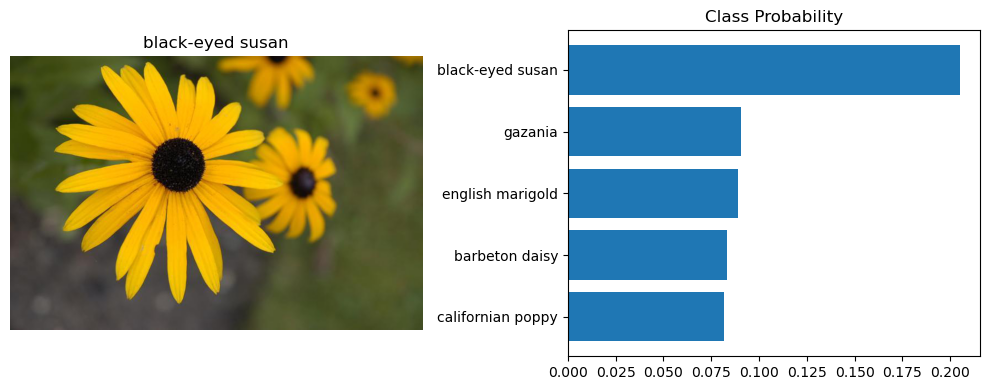

Classification results displayed. Check the pop-up window.


In [24]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

from helper.common_utils import print_device_info, set_device_for_gpu
from helper.constant import test_dir
from helper.image import process_image, pick_a_pic
from helper.input import get_predict_input_arg
from helper.load import load_categories, transform_load, load_checkpoint
from helper.validate import validate_predict_args

from predict import predict 


device = set_device_for_gpu()
start_time = datetime.now()

args = get_predict_input_arg([])
args.top_k =5

print('\n*** Command line arguments ***')
print(f'Checkpoint: {args.checkpoint}\nImage path: {args.img_pth}'
      f'\nCategory names mapper file: {args.category_names}\nNumber of top k: {args.top_k}'
      f'\nGPU mode: {args.gpu}\n')

validate_predict_args(args)
print_device_info(device, args)

dataloaders, _ = transform_load(args)
model, arch = load_checkpoint(device, args)

elapsed = datetime.now() - start_time
print(f'\n*** Prediction setup done!\nElapsed time: {elapsed}\n')

args = pick_a_pic(dataloaders, test_dir, 'test', args)
image_path = args.z_rndimgpth
print(f'Image path: {image_path}\n')

print("Predicting top classes and probabilities...")
_, topk_names, topk_probs = predict(model, arch, image_path, args.top_k, device)
print("Prediction complete.")

# Display the image and a bar chart of the top class probabilities
print("Displaying classification results...")
show_classifier(topk_names, topk_probs, image_path)
print("Classification results displayed. Check the pop-up window.")